In [1]:
import time
import picamera
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.figure_format = "svg"
import sys
sys.path.append("..")
import SHSlib  as sh

#%load_ext autoreload
#%autoreload 2

In [2]:
with picamera.PiCamera(
        sensor_mode= 4,  # 1640x1232, full FoV, binning 2x2
        resolution= (640,480),
        framerate= 90
) as camera:
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2
    camera.shutter_speed = int(6e5)
    camera.iso = 1
    output = np.zeros((480,640,3), dtype=np.uint8)
    while True: 
        %time camera.capture(output,'rgb',use_video_port=True)
        t2 = time.time_ns()
        img = Image.fromarray(output,'RGB')
        display(img,clear=True)    

KeyboardInterrupt: 

In [2]:

indx = 0 
resolution = (640//2,480//2)
#resolution = (640,480)
#resolution = (1280,720)
#resolution = (1640,1232)
#resolution =(2016, 1520)

min_distance = 80

indx_end = 1000

with picamera.PiCamera(
    # Camera Setup 
    sensor_mode= 4,  
    resolution= resolution,
    framerate= 30
) as camera:
    #setup Ploting
    
    
    
    # addition camera setup
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2.5

    camera.shutter_speed = int(6e6)
    camera.iso = 50
    output = np.zeros((*reversed(resolution),3), dtype=np.uint8)
    
    # get ref image
    for i in range(5):
        camera.capture(output,'rgb',use_video_port=True)
        
    PIL_ref_img = Image.fromarray(output,'RGB')
    ref_img = np.mean(PIL_ref_img,2) 
    
    # precess pef image
    ref_lables = sh.analyse.getSeperation(ref_img,min_distance=min_distance)
    ref_center = sh.analyse.getMomentum(ref_lables,ref_img, algorythm="C") 
    ShiftOverTimeX = np.zeros((len(ref_center[0]),indx_end))
    ShiftOverTimeY = np.zeros((len(ref_center[0]),indx_end))
    
    timeOfCapture = np.zeros(indx_end)
    timeOfCapture[0] = 0

    
    fig = plt.figure(figsize=(10,10))
    axSensor = fig.add_subplot(321)
    axPeakArea = fig.add_subplot(322)
    axPeakPosOverTime = fig.add_subplot(312)
    axPeakPosOverTime2 = fig.add_subplot(313)
    #axPeakPosOverTime2 = fig.add_subplot(211)

    imageSensorImg =  axSensor.imshow(PIL_ref_img)
    
    imagePeakArea = axPeakArea.imshow(ref_lables)
    linePeakPoints1 = axPeakArea.plot(ref_center[0],ref_center[1],"r.",label='refPos',linewidth=0.1,alpha=0.4)
    linePeakPoints2 = axPeakArea.plot(ref_center[0],ref_center[1],"y.",label='Pos',linewidth=0.1,alpha=0.4)
    axPeakArea.legend()
    


    
    linePeakPosOverXTime = []
    linePeakPosOverYTime = []
    for i in range(len(ref_center[0])):
        linePeakPosOverXTime += [axPeakPosOverTime.plot(ref_center[0][i])]
        linePeakPosOverYTime += [axPeakPosOverTime2.plot(ref_center[1][i])]
    fig.canvas.draw()
    plt.show()
    
        
    
    t0 = time.time_ns()
    
    for i in range(0,indx_end):
        t1 = time.time_ns()
        # continuous capture 
        %time camera.capture(output,'rgb',use_video_port=True) # 50ms
        timeOfCapture[i] = (time.time_ns() - t0) /1e9
        
        Sensor_img = Image.fromarray(output,'RGB') #5ms
        
        img = np.int16(output)
        img = np.uint8((img[:,:,0] + img[:,:,1] + img[:,:,2])/3)

        #%time img = np.mean(Sensor_img,2)
        
        center = sh.analyse.getMomentum(ref_lables, img, algorythm="C") 
        partners = sh.analyse.getPartner(center, ref_center)
        
        
        ShiftOverTimeX[:,i] = partners[0]
        ShiftOverTimeY[:,i] = partners[1]
        
        print((time.time_ns() - t1)/1e6)
        if True: #i%0 == 0:
            # Set data for Ploting
            imageSensorImg.set_data(Sensor_img) 

            #imagePeakArea.set_data(img)

            linePeakPoints2[0].set_xdata(center[0])
            linePeakPoints2[0].set_ydata(center[1])
            axSensor.set_title("Index :" + str(indx))


            for j in range(len(ShiftOverTimeX[:,i])):
                linePeakPosOverYTime[j][0].set_ydata(ShiftOverTimeX[j,0:i+1])
                linePeakPosOverYTime[j][0].set_xdata(timeOfCapture[0:i+1])

                linePeakPosOverXTime[j][0].set_ydata(ShiftOverTimeY[j,0:i+1])
                linePeakPosOverXTime[j][0].set_xdata(timeOfCapture[0:i+1])
                
                axPeakPosOverTime.relim() 
                axPeakPosOverTime.autoscale_view(True,True,True) 
                
                axPeakPosOverTime2.autoscale_view(True,True,True) 
                axPeakPosOverTime2.relim() 
            fig.canvas.draw()
        indx += 1 


IndexError: arrays used as indices must be of integer (or boolean) type

 ## Timing examples

In [6]:

indx = 0 

resolution = (640,480)
#resolution = (1280,720)
#resolution = (1640,1232)
#resolution =(2016, 1520)

min_distance = 80

indx_end = 1000

with picamera.PiCamera(
    # Camera Setup 
    sensor_mode= 4,  
    resolution= resolution,
    framerate= 30
) as camera:
     # addition camera setup
    time.sleep(1)  # let the camera warm up and set gain/white balance
    camera.exposure_mode = 'off'
    camera.awb_mode = 'off'
    camera.awb_gains = 2.5

    camera.shutter_speed = int(6e6)
    camera.iso = 50
    output = np.zeros((*reversed(resolution),3), dtype=np.uint8)
    
    # get ref image
    for i in range(5):
        camera.capture(output,'rgb',use_video_port=True)
        
    PIL_ref_img = Image.fromarray(output,'RGB')
    ref_img = np.mean(PIL_ref_img,2) 
    
    # precess pef image
    ref_lables = sh.analyse.getSeperation(ref_img,min_distance=min_distance)
    ref_center = sh.analyse.getMomentum(ref_lables,ref_img, algorythm="C") 
    ShiftOverTimeX = np.zeros((len(ref_center[0]),indx_end))
    ShiftOverTimeY = np.zeros((len(ref_center[0]),indx_end))
    
    timeOfCapture = np.zeros(indx_end)
    timeOfCapture[0] = 0
    
    t0 = time.time_ns()
    
    for i in range(0,indx_end):
        t1 = time.time_ns()
        # continuous capture 
        camera.capture(output,'rgb',use_video_port=True) # 50ms
        timeOfCapture[i] = (time.time_ns() - t0) /1e9
        
        Sensor_img = Image.fromarray(output,'RGB') #5ms
        
        img = np.int16(output)
        img = np.uint8((img[:,:,0] + img[:,:,1] + img[:,:,2])/3)

        #%time img = np.mean(Sensor_img,2)
        
        center = sh.analyse.getMomentum(ref_lables, img, algorythm="C") 
        partners = sh.analyse.getPartner(center, ref_center)
        
        
        ShiftOverTimeX[:,i] = partners[0]
        ShiftOverTimeY[:,i] = partners[1]
        display(clear=True)
        print("idx: " + str(indx) + "  " + str((time.time_ns() - t1)/1e6))
        indx += 1 
        

idx: 198  190.217537


KeyboardInterrupt: 

In [19]:
end

array([ 0., -1.,  0., -1.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1.,
       -1.,  0., -1., -1.,  0.,  0., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  0., -1., -1.,  0., -1.,  0., -1., -1., -1., -1.,
       -1., -1.,  0.,  0., -1., -1.,  0., -1., -1.,  0., -1., -1.,  0.,
        0., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0., -1.,
       -1.,  0., -1.,  0., -1., -1., -1.,  0., -1.,  0., -1.,  0., -1.,
       -1., -1.,  0.,  0., -1., -1., -1.,  0., -1., -1., -1.,  0.,  0.,
        0.,  0., -1., -1.,  0.,  0., -1.,  0., -1., -1.,  0., -1., -1.,
       -1., -1., -1., -1., -1.,  0., -1.,  0.,  0., -1., -1., -1.,  0.,
       -1., -1., -1., -1., -1., -1.,  0., -1.,  0., -1., -1., -1., -1.,
        0.,  0., -1., -1.,  0., -1., -1., -1.,  0.,  0., -1.,  0., -1.,
        0.,  0., -1., -1., -1., -1., -1.,  0.,  0., -1., -1., -1.,  0.,
        0., -1., -1.,  0., -1.,  0., -1., -1., -1.,  0., -1., -1., -1.,
        0., -1., -1., -1., -1., -1.,  0., -1.,  0., -1., -1., -1

In [40]:
(i+1)*win

990

In [39]:
i*win

987

In [38]:
plt.plot(ShiftOverTimeX.T[:,1])

win = 3

sig = ShiftOverTimeX.T[:,1]
end = len(sig)//3

m = np.zeros((end))

for i in range((end-1*win)):
    m[i] = np.mean(sig[i*win:(i+1)*win])
    



<IPython.core.display.Javascript object>


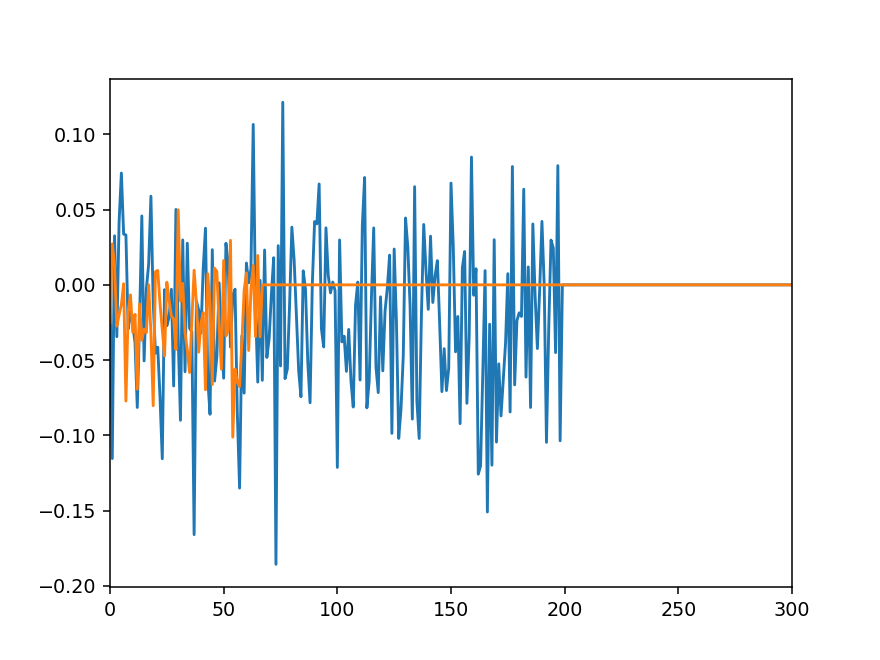

(0.0, 300.0)

In [45]:
plt.plot(ShiftOverTimeX.T[:,1])
plt.plot(m)
plt.xlim((0,300))